In [1]:
%matplotlib inline

# Import python modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import sys

import itable

from linkage_tools import *
from Probabilistic import *
from Perceptron import *

from NeuralNetwork import *

l = Linker()

#import warnings
#warnings.filterwarnings('error')

verbose = True

### Define linking variables

In [2]:
# Define tables
tableA = '''patient_discharges JOIN newborns
ON patient_discharges.id = newborns.patient_discharge_id
LEFT OUTER JOIN patient_payers AS newborn_payers
ON newborn_payers.patient_discharge_id = patient_discharges.id'''

tableB = '''births JOIN deliveries 
ON births.delivery_id = deliveries.id
JOIN patient_discharges AS delivery_discharges
ON deliveries.patient_discharge_id = delivery_discharges.id
LEFT OUTER JOIN patient_payers AS delivery_payers
ON delivery_payers.patient_discharge_id = delivery_discharges.id'''

# Define fields to compare tables by
tableA_fields = ['patient_discharges.sex_id','newborns.id','newborns.cesarean_section', 
            'patient_discharges.zip_code','patient_discharges.race_id','patient_discharges.ethnicity_id', 
                'newborn_payers.payer_type_of_coverage_id','patient_discharges.principal_language_spoken', 
                 'patient_discharges.discharged_on','newborn_payers.payer_category_id',
                 'newborn_payers.plan_code_number','newborns.birth_weight_group_id',
                 'newborns.gestational_age_group_id','newborns.plurality_group_id']

tableB_fields = ['births.sex_id','births.newborn_id','births.delivery_route_id', 
            'births.mothers_residence_zip_code','delivery_discharges.race_id','delivery_discharges.ethnicity_id', 
                'delivery_payers.payer_type_of_coverage_id','delivery_discharges.principal_language_spoken', 
                 'delivery_discharges.discharged_on','delivery_payers.payer_category_id',
                 'delivery_payers.plan_code_number','births.birth_weight',
                 'births.gestational_age_ob_estimate','births.plurality'] 

feature_vals = ['sex_id','c_section','zip_code','race','ethnicity','payer_type_of_coverage_id',
                'language_spoken','discharge','payer_category_id','plan_code_number','weight_group_id',
                'gest_age_group_id','plurality','weight_plus','weight_minus','gest_age_plus','gest_age_minus']

# Define bins to use for certain fields
age_bins = np.concatenate(([1,24], np.arange(25, 36, 2),[99]), axis=0)
bw_bins = np.concatenate(([1], np.arange(500, 2001, 250),[2500,9999]), axis=0)

cesarean_ids = [1, 11, 21, 31, 2, 12, 22, 32]
    
# Define conditions (expressions) on which to compare fields
conditions = [  "cross_table['sex_id_x']==cross_table['sex_id_y']",
                "cross_table['cesarean_section']==[x in cesarean_ids for x in cross_table['delivery_route_id']]",
                "cross_table['zip_code']==cross_table['mothers_residence_zip_code']",
                "cross_table['race_id_x']==cross_table['race_id_y']",
                "cross_table['ethnicity_id_x']==cross_table['ethnicity_id_y']",
                "cross_table['payer_type_of_coverage_id_x']==cross_table['payer_type_of_coverage_id_y']",
                "cross_table['principal_language_spoken_x']==cross_table['principal_language_spoken_y']",
                "cross_table['discharged_on_x']==cross_table['discharged_on_y']",
                "cross_table['payer_category_id_x']==cross_table['payer_category_id_y']",
                "cross_table['plan_code_number_x']==cross_table['plan_code_number_y']",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)",
                "cross_table['gestational_age_group_id']==np.digitize(list(cross_table['gestational_age_ob_estimate']/7),age_bins)+1",
                "(cross_table['plurality_group_id']==1)==(cross_table['plurality']==1)",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)+1",
                "cross_table['birth_weight_group_id']==np.digitize(list(cross_table['birth_weight']),bw_bins)-1",
                "cross_table['gestational_age_group_id']==np.digitize(list(cross_table['gestational_age_ob_estimate']),age_bins)+2",
                "cross_table['gestational_age_group_id']==np.digitize(list(cross_table['gestational_age_ob_estimate']),age_bins)"  ] 

simple_features = feature_vals[0:13]
complex_features = feature_vals[13:]

### Blocking

In [3]:
# Find all possible values for 1st blocking field ('hospital_id')
stmt = '''
SELECT DISTINCT patient_discharges.hospital_id
FROM patient_discharges 
UNION
SELECT DISTINCT births.hospital_id
FROM births;'''
block_list1 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

block_list1 = block_list1[0:1]

# Find all possible values for 2nd blocking field ('date_of_delivery')
stmt = '''
SELECT DISTINCT births.date_of_delivery
FROM births;'''
block_list2 = [x[0] for x in l.exec_sql(stmt).values.tolist()]

block_list2 = block_list2[600:650]

block_prod = [(str(x),str(y)) for x in block_list1 for y in block_list2]

# Assign strings to select each block
blocking_stmt1 = '''
        SELECT patient_discharges.id AS pdd_id, newborns.id AS newb_id,%s 
        FROM %s
        WHERE patient_discharges.hospital_id = %r
        AND patient_discharges.date_of_birth = %r;
        '''
blocking_stmt2 = '''
        SELECT births.id AS bc_id,%s
        FROM %s
        WHERE births.hospital_id = %r
        AND births.date_of_delivery = %r;
        '''

### Create classifiers and iterate over each block
- Create [probabilistic] and [perceptron] classifier (train each on selected subset of features ['simple' vs. 'complex'])
- Loop over each block and convert to pandas dataframe
- Cross join the features-of-interest from both blocks
- Apply conditional statements to each column of dataframe
- Return match score from each learner
- Maximize pairing with Kuhn-Munkres (i.e. Hungarian) Algorithm [more info]
- Compare guesses to truth, update weights/probabilities

[more info]: https://pypi.python.org/pypi/munkres/
[perceptron]: http://glowingpython.blogspot.com/2011/10/perceptron.html
[probabilistic]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5005943/

In [5]:
learning_rate = 0.005 # small, constant learning rate for perceptron

# Create instances of classifiers
pr_simple = Probabilistic(len(simple_features)) # probabilistic linkage (simple features only)
pr_complex = Probabilistic(len(conditions)) # probabilistic linkage (all features)

pt_simple = Perceptron(len(simple_features),learning_rate) # single-layer perceptron (simple features only)
pt_complex = Perceptron(len(conditions),learning_rate) # single-layer perceptron (all features)

learning_rate = 0.1
nn_complex = NeuralNetwork(len(conditions),10,1,learning_rate) # multi-layer neural network

classifiers = ['pr_simple','pr_complex','pt_simple','pt_complex','nn_complex']
classifier_features = [simple_features,feature_vals,simple_features,feature_vals,feature_vals]
class_prog = [True] * len(classifiers)

iter_qual_list = []
iter_score_list = []
block_duration = []
epoch_duration = []
epoch_count = 0
verb_str = '\rEpoch #{}, blockA: {} records, blockB: {} records  ' # verbose output

while True:
    epoch_start = time.time() # Measure epoch duration
    big_bool = pd.DataFrame(columns=feature_vals)  

    for block1, block2 in block_prod:
        
        block_start = time.time() # Measure block duration

        # Create blocks
        blockA = l.exec_sql(blocking_stmt1 % (",".join(tableA_fields),tableA,block1,block2))
        blockB = l.exec_sql(blocking_stmt2 % (",".join(tableB_fields),tableB,block1,block2))
        
        if verbose:
            sys.stdout.write(verb_str.format(epoch_count+1, len(blockA), len(blockB)))
            sys.stdout.flush()
        # Check that neither block is empty - If empty, skip to next record-pair in loop
        if (len(blockA)==0) or (len(blockB)==0):
            continue

        # Cross-join both blocks
        cross_table = l.df_crossjoin(blockA, blockB)

        # Count field matches and dump each into new column of dataframe
        bool_table = pd.DataFrame.from_items(zip(feature_vals,[eval(x).values for x in conditions]))

        # Add record-id columns to boolean table
        bool_table['newb_id'] = cross_table['newb_id'].values # Actual newborn id
        bool_table['bc_id'] = cross_table['bc_id'].values  # Actual bc id
        bool_table['prev_newb_id'] = cross_table['newborn_id'].values # Originally matched newborn id 
        
        # Compare with previously-linked newborn id
        bool_table['real_match'] = (cross_table['newborn_id']==cross_table['newb_id']).values 
        for x in classifiers:
            bool_table['match_'+x] = False # Create new columns for later
        
        # Get guesses from classifiers
        record_id = bool_table[['newb_id','bc_id']]
        for x,y in zip(classifiers,classifier_features):
            link_inds,link_score = eval(x).query(bool_table[y],record_id) 
            bool_table['lscore_'+x] = link_score
            bool_table.loc[link_inds,'match_'+x] = True # Label nominees as such  
        
        # Aggregate field-match tables (Booleans) within loop
        big_bool = pd.concat([big_bool,bool_table])
    
        # Time duration of each block
        block_duration.append(time.time()-block_start)
        
    mark = int(round(len(big_bool)*.9))
    
    #train_data = big_bool.iloc[0:mark]
    #test_data = big_bool.iloc[mark:]

    # Train probabilistic classifiers
    if class_prog[classifiers.index('pr_simple')]: # If still progressing...
        pr_simple.train(big_bool[simple_features],big_bool['real_match'])
    if class_prog[classifiers.index('pr_complex')]:
        pr_complex.train(big_bool[feature_vals],big_bool['real_match'])
        
    # Train perceptron classifiers
    if class_prog[classifiers.index('pt_simple')]:
        pt_simple.train(big_bool[simple_features],big_bool['real_match'],big_bool['match_pt_simple'])
    if class_prog[classifiers.index('pt_complex')]:
        pt_complex.train(big_bool[feature_vals],big_bool['real_match'],big_bool['match_pt_complex'])

    # Train neural network classifiers
    if class_prog[classifiers.index('nn_complex')]:
        nn_complex.train(big_bool[feature_vals],big_bool['real_match'],big_bool['match_nn_complex'])
    
    # Measure accuracy of each classifier
    score_list = [((big_bool['match_'+x]==big_bool['real_match'])*1).tolist() for x in classifiers]
    cur_scores = [sum(x)*100.0/len(x) for x in score_list]
    iter_score_list.append(cur_scores)
    
    # Set range of linkage scores (0 through 100 percentiles) i.e. decision threshold (theta)
    set_thetas = range(0,100,10)
    
    # Update precision & recall of classifiers
    for x in classifiers:
        eval(x).prec_recall(big_bool['lscore_'+x],set_thetas,big_bool['real_match'])
    
    # Compare current iteration 'quality' with previous iterations
    cur_iter_qual = [eval(x).iter_qual_list[-1] for x in classifiers]
    prev_iter_qual = [eval(x).iter_qual_list[-2] for x in classifiers]
    class_prog = np.subtract(cur_iter_qual,prev_iter_qual)>.1
    iter_qual_list.append(cur_iter_qual)
    
    # If not improving > Break from outer loop
    if not any(class_prog):
        print str.format('\n'+'-'*80+"\n'Quality' achieved! @ {}",[ float('%.2f' % x) for x in cur_iter_qual ])        
        # ADD READ-OUT OF 'WRONG' MATCHES HERE!!!!!
        # MAYBE USE cur_scores?
        break

    # Time duration of each iteration
    epoch_duration.append(time.time()-epoch_start)
    
    epoch_count += 1 # Increment epoch counter
    
    if verbose:
        print str.format('\nAverage block duration: {0:.2f} seconds', np.mean(block_duration))
        print str.format("'Quality': {}", [ float('%.2f' % x) for x in cur_iter_qual ])
        print str.format('% correct: {}', [ float('%.4f' % x) for x in cur_scores ])
        print str.format('Average epoch duration: {0:.3f} minutes', np.mean(epoch_duration)/60.0)

Epoch #1, blockA: 12 records, blockB: 12 records  
Average block duration: 0.17 seconds
'Quality': [108.27, 100.76, 44.61, 43.73, 42.26]
% correct: [99.7755, 99.7755, 89.3851, 89.41, 27.9094]
Average epoch duration: 0.322 minutes
Epoch #2, blockA: 12 records, blockB: 12 records  
Average block duration: 0.16 seconds
'Quality': [124.87, 124.38, 123.41, 120.83, 101.54]
% correct: [99.8753, 99.8503, 99.8004, 99.8254, 98.2724]
Average epoch duration: 0.309 minutes
Epoch #3, blockA: 12 records, blockB: 12 records  
Average block duration: 0.16 seconds
'Quality': [124.87, 124.38, 123.41, 127.87, 112.21]
% correct: [99.8753, 99.8503, 99.8004, 99.8254, 98.2849]
Average epoch duration: 0.308 minutes
Epoch #4, blockA: 12 records, blockB: 12 records  
Average block duration: 0.15 seconds
'Quality': [124.87, 124.38, 123.41, 121.51, 115.51]
% correct: [99.8753, 99.8503, 99.8004, 99.8254, 98.4969]
Average epoch duration: 0.303 minutes
Epoch #5, blockA: 12 records, blockB: 12 records  
Average block 

In [30]:
### if None in blockA ---------RESUME HERE!!!!! 
cross_table['payer_type_of_coverage_id_x']==cross_table['payer_type_of_coverage_id_y']
# payer_type_of_coverage_id_x
print(cross_table['payer_type_of_coverage_id_x'][0])

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
Name: payer_type_of_coverage_id_x, dtype: object


In [35]:
### GET READ-OUT OF 'WRONG ANSWERS'

score_list = [((big_bool['match_'+x]==big_bool['real_match'])*1).tolist() for x in classifiers]

errors =  big_bool.iloc[[x==0 for x in score_list[0]],:].sort(['bc_id','real_match'], ascending=[1,0])
print errors

     bc_id c_section discharge ethnicity gest_age_group_id gest_age_minus  \
314  33776      True      True      True             False          False   
254  33776      True      True      True             False          False   
256  33779      True      True      True             False          False   
316  33779      True      True      True             False          False   
10   34011      True      True      True             False          False   
62   34011      True      True      True             False          False   
63   34013      True      True      True             False          False   
11   34013      True      True      True             False          False   
149  34178      True      True      True             False          False   
110  34178      True      True      True             False          False   
116  34200      True      True      True             False          False   
155  34200      True      True      True             False          False   

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


### Plot precision/recall for each epoch of probabilistic record linkage

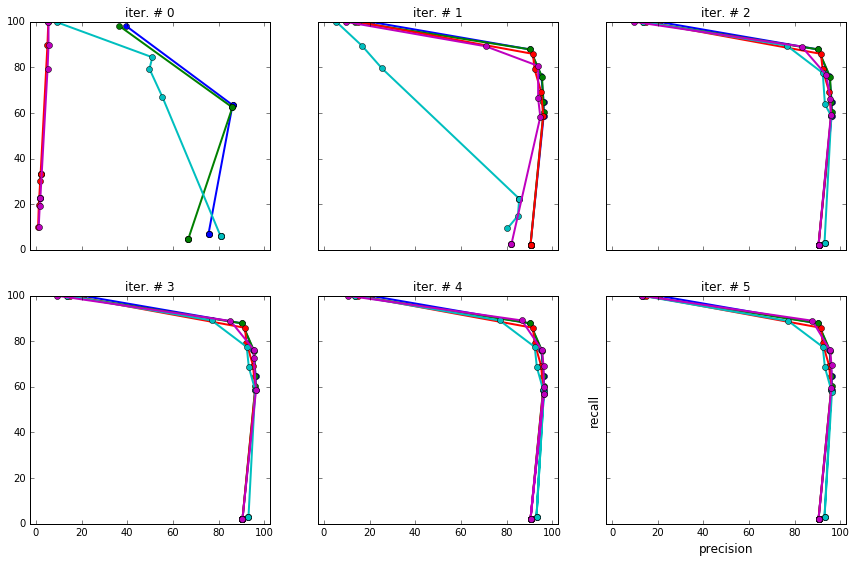

In [5]:
deltas = np.diff(pr_complex.iter_qual_list)

learner_list = [eval(x) for x in classifiers]
plot_prec_list = [o.precision_list for o in learner_list]
plot_recall_list = [o.recall_list for o in learner_list]
color_list = ['b','g','r','c','m'][slice(len(learner_list))]

ncol = int(np.ceil(np.sqrt(len(plot_prec_list[0]))))
nrow = int(np.ceil(len(plot_recall_list[0])/float(ncol)))
fig, axs = plt.subplots(nrow, ncol, sharex='col', sharey='row')
for i, ax in enumerate(fig.axes[0:len(plot_prec_list[0])]):   
    plot_curves = lambda w,x,y: ax.plot(w[i], x[i], '-', linewidth=2, marker='o', color=y)
    map(plot_curves,plot_prec_list,plot_recall_list,color_list)
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])
    ax.set_title("iter. # {}".format(str(i)), fontsize=12)
    ax.set(aspect='equal')    
else:
    ax.set_xlabel('precision', fontsize=12)
    ax.set_ylabel('recall', fontsize=12)

fig.set_size_inches(4.875*ncol,4.5*nrow)
plt.show()
fig.savefig('prec_recall.png')

### Plot accuracy for each classifier over all epochs

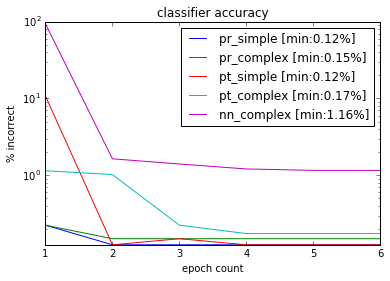

In [17]:
x = range(1,epoch_count+2)
y = 100-np.array(score_qual_list, ndmin=2, dtype=np.float).T
fig = plt.figure()
plt.yscale('log')
plt.ylim((y.min(),100))
plt.title("classifier accuracy")
for quals,cl in zip(y,classifiers):
    plt.plot(x,quals,label = cl+' [min:'+str('%.2f' % quals.min())+'%]')
plt.xlabel("epoch count")
plt.ylabel("% incorrect")
plt.legend(loc='upper right')
plt.show()

fig.savefig('classifier_accuracy.png')

### Show table of weights/probabilities for each classifier

In [25]:
# Assemble table elements into dataframe
pt_simple_weights = pt_simple.weights.tolist()[:-1] + [None]*len(complex_features) + [pt_simple.weights.tolist()[-1]]
weight_list = [['pr_complex'] + pr_complex.m_probs.tolist() + [None],
               ['pr_simple'] + pr_simple.m_probs.tolist() + [None],
               ['pt_complex'] + pt_complex.weights.tolist(),
               ['pt_simple'] + pt_simple_weights]
df = pd.DataFrame(weight_list, columns=['classifier']+feature_vals+['bias'])

# Save table as html file
my_file = open('weights.html', 'w')
my_file.write(df.to_html())
pt_simple_weights = pt_simple.weights.tolist()
my_file.close()

# Show table as ipython figure
itable.PrettyTable(df)

classifier,sex_id,c_section,zip_code,race,ethnicity,payer_type_of_coverage_id,language_spoken,discharge,payer_category_id,plan_code_number,weight_group_id,gest_age_group_id,plurality,weight_plus,weight_minus,gest_age_plus,gest_age_minus,bias
pr_complex,0.970114942529,0.990804597701,0.890804597701,0.888505747126,0.929885057471,0.0,0.902298850575,0.881609195402,0.0,0.0,0.0747126436782,0.0287356321839,0.994252873563,0.00229885057471,0.00574712643678,0.0,0.0275862068966,nan
pr_simple,0.970114942529,0.990804597701,0.890804597701,0.888505747126,0.929885057471,0.0,0.902298850575,0.881609195402,0.0,0.0,0.0747126436782,0.0287356321839,0.994252873563,nan,nan,nan,nan,nan
pt_complex,0.163240970757,0.306832617223,0.227058625352,0.159088905318,0.0783341304078,6.61924526531e-05,0.174885628943,0.229271514561,0.00526277212269,0.00407169733123,0.0360792697616,-0.00697362099136,0.0640323030053,-0.000675268329695,-0.017911928144,-0.00630011102413,0.00815196098021,-0.00482794746214
pt_simple,2.91830838155,1.52186911446,3.84791067531,0.805726010688,2.02900348594,-0.00905111986157,2.85289800246,3.36583366228,-0.00491512610326,0.00269076293744,0.24749030433,-0.0150981020741,0.460858409095,nan,nan,nan,nan,0.00322693864553


In [11]:
# Show equivalence between row-iteration and matrix multiplication
inputs_list = bool_table[feature_vals]
predictions,score = pt_complex.query(inputs_list)
targets = np.array(bool_table['match'], ndmin=2)

inputs = np.array(inputs_list, ndmin=2)
inputs = np.concatenate((inputs,np.repeat(1, len(inputs[:,1]))[:, None]), axis=1) # Add bias input
weights = np.random.uniform(low=-0.01, high=0.01, size=len(inputs[1,:]))
    
output_errors = targets-predictions
print output_errors
#print inputs.shape,weights.shape,output_errors.shape

#print learning_rate * np.dot(output_errors, inputs)

for i,row in enumerate(inputs):
    foo = output_errors[:,i] * row
    weights += learning_rate * output_errors[:,i] * row
#print weights

[[ 0.  0.  0.  0. -1.  0.  0. -1.  0. -1. -1. -1. -1. -1. -1.  0.]]


In [11]:
cutoff = theta[-1]
winners = (big_bool['linkage_score']>cutoff)
print sum(winners&big_bool['real_match'])
print sum(winners&big_bool['pair_match']&big_bool['real_match'])
print sum(big_bool['pair_match']&big_bool['real_match'])

# Precision: the percent of pairs with a score above theta that are real matches
# USE ONLY NOMINATED PAIRS
# - numerator: number of NOMINATED pairs with a score above theta that are real matches
real_picks = sum(winners&big_bool['real_match']&big_bool['pair_match'])
# - denominater: number of NOMINATED pairs with a score above theta
picks = sum(winners&big_bool['pair_match'])
precision = (real_picks/float(picks)*100)

# Recall: the percent of known matched pairs that get a score above theta
# - numerator: number of NOMINATED pairs with a score above theta that are real matches
# - denominater: number of pairs that are real matches
real_matches = big_bool['real_match'].sum()
recall = (real_picks/float(real_matches)*100)

print precision,recall

37
32
484
84.2105263158 4.59110473458


In [ ]:

"""
[1,  '< 500g',          1,    1 ..  499, 1],
    [2,  '500 to 749g',     2,  500 ..  749, 1],
    [3,  '750 to 999g',     3,  750 ..  999, 1],
    [4,  '1,000 to 1,250g', 4, 1000 .. 1250, 2],
    [5,  '1,250 to 1,499g', 5, 1250 .. 1499, 2],
    [6,  '1,500 to 1,749g', 6, 1500 .. 1749, 3],
    [7,  '1,750 to 1,999g', 7, 1750 .. 1999, 4],
    [8,  '2,000 to 2,499g', 8, 2000 .. 2499, 5],
    [9,  '> 2,500g',        9, 2500 .. 9999, 6],
    # Overweight?!?
    [11, 'Unknown',         0, []],
"""


data = list(cross_table['birth_weight'])
        
bw_bins = np.concatenate(([1], np.arange(500, 2001, 250),[2500,9999]), axis=0)
print bw_bins

inds = np.digitize(data, bw_bins)

for n in range(len(data)):
    print(bw_bins[inds[n]-1], "<=", data[n], "<", bw_bins[inds[n]])


In [ ]:
data = cross_table['gestational_age_ob_estimate']/7

# '<24 weeks','24 weeks','25-26 weeks','27-28 weeks',...'35-36 weeks','37 or more weeks'
        
bins = np.concatenate(([0,24], np.arange(25, 36, 2),[99]), axis=0)
print bins

inds = np.digitize(data.tolist(), bins)

for n in range(len(data)):
    print(bins[inds[n]-1], "<=", data[n], "<", bins[inds[n]])


In [3]:
"""
# Find relative frequencies of values in each field
# - save each as dictionary (1 dict per field per table)
rel_freq_tA = {}
for i in tableA_fields:
    stmt = '''SELECT {0} value, COUNT(*) count
    FROM {1}
    GROUP BY {0};'''.format(i,tableA)
    field_dict = exec_statement(stmt,'dict')
    rel_freq_tA[i] = dict(zip(field_dict['value'],field_dict['count']))
    
rel_freq_tB = {}
for i in tableB_fields:
    stmt = '''SELECT {0} value, COUNT(*) count
    FROM {1}
    GROUP BY {0};'''.format(i,tableB)
    field_dict = exec_statement(stmt,'dict')
    rel_freq_tB[i] = dict(zip(field_dict['value'],field_dict['count']))

# BROKEN
def rel_freq(table_fields,table):
    # Find relative frequencies of values in each field
    # - save each as dictionary (1 dict per field per table)
    freq_out = {}
    for i in table_fields:
        stmt = '''SELECT {0} value, COUNT(*) count
        FROM {1}
        GROUP BY {0};'''.format(i,table)
        field_dict = l.exec_sql(stmt).to_dict()
        print field_dict
        freq_out[i] = dict(zip(field_dict['value'],field_dict['count']))
    
rel_freq_tA = rel_freq(tableA_fields,tableA)
rel_freq_tB = rel_freq(tableB_fields,tableB)
"""


"\n# Find relative frequencies of values in each field\n# - save each as dictionary (1 dict per field per table)\nrel_freq_tA = {}\nfor i in tableA_fields:\n    stmt = '''SELECT {0} value, COUNT(*) count\n    FROM {1}\n    GROUP BY {0};'''.format(i,tableA)\n    field_dict = exec_statement(stmt,'dict')\n    rel_freq_tA[i] = dict(zip(field_dict['value'],field_dict['count']))\n    \nrel_freq_tB = {}\nfor i in tableB_fields:\n    stmt = '''SELECT {0} value, COUNT(*) count\n    FROM {1}\n    GROUP BY {0};'''.format(i,tableB)\n    field_dict = exec_statement(stmt,'dict')\n    rel_freq_tB[i] = dict(zip(field_dict['value'],field_dict['count']))\n\n# BROKEN\ndef rel_freq(table_fields,table):\n    # Find relative frequencies of values in each field\n    # - save each as dictionary (1 dict per field per table)\n    freq_out = {}\n    for i in table_fields:\n        stmt = '''SELECT {0} value, COUNT(*) count\n        FROM {1}\n        GROUP BY {0};'''.format(i,table)\n        field_dict = l.exec_s

### Update 'births' table accordingly

In [ ]:
foo = fin_bool.loc[big_bool['pair_match']==1]
for index, row in foo.iterrows():     
    stmt1 = '''
        UPDATE births 
        SET newborn_id_2 = %d, newborn_linkage_score_2 = %s
        WHERE id = %d;
        ''' % (row['newb_id'], row['linkage_score'], row['bc_id'])
    exec_statement(stmt1)